In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures


In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [80]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
def build_dataset(names):
    X,y = [],[]
    context_size = 3
    # names1 = names[:4]
    for name in names:
        context = [0]*context_size
        # print(name)
        name += '.'
        for i,ch in enumerate(name):
            X.append(context)
            y.append(stoi[ch])
            # print(f'x: {name[:i]}, y:{ch}')
            # print(context)
            context = context[1:] + [stoi[ch]]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X,y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [16]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

### He initialisation
* Proper initialisation helps mainiting the weights across the network in same scale, so there won't blow up or shrink
* let's say 3rd layer has weights of range (1000,10000), then the gradient of this will be very high, it will blow up the previous layers update if it's of very small scale -- Blows Up
* If 3rd layer weights has weights of small scale and 2nd layer has large scale, then gradient of 3rd layer won't help us in updating the 2nd layer's weights
* **He initalisation** also helps us in reducing the **Internal Covariance Shift**, A phenominon that slows down the training process when every layer has to deal with previous layers weight update, which changes the current layers input distribution

In [166]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5) # * 0.01 # initialising these weights near 0 will escape from tanh saturation region
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01; #fixing these last layers helps in fixing the large initial loss
b2 = torch.randn(vocab_size, generator=g) * 0  
bngain = torch.ones((1, n_hidden)) # batch normalisation gain, These help the network to move and shape the gaussian 
bnbias = torch.zeros((1, n_hidden)) # batch normalisation bias
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))
parameters = [C, W1, b1, W2, b2,bngain, bnbias]

In [167]:
for p in parameters:
  p.requires_grad = True

In [168]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [169]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  hpreact  = emb.view(-1, 30) @ W1  # + b1 # (32, n_hidden)
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi =  hpreact.std(0, keepdim= True)
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
  break

#print(loss.item())

In [171]:
lossi

[0.5212695002555847]

## Fixing the tanh saturation
* The below two are the histograms before and after applying tanh on hidden outputs. We can see most of the values are in the saturated ragion of tanh, due to which we can't pass on the gradients(due to its first derivative) during backward propogation
* To avoid this we need to initialise out weights small and around zero. The muliplication we factor we are using is making the std of the weights to be around one, which is calculated using He initialisation, it depends on the non-linearity (gain, (5/3) for tanh) we are using and no of inputs.

(array([  2.,   3.,   5.,   6.,  11.,  12.,  14.,  30.,  30.,  63.,  78.,
         83., 117., 132., 168., 194., 215., 250., 276., 316., 372., 381.,
        396., 400., 394., 312., 350., 288., 302., 224., 215., 168., 152.,
        114.,  80.,  79.,  46.,  37.,  28.,  15.,  11.,  13.,   5.,   4.,
          2.,   2.,   2.,   0.,   1.,   2.]),
 array([-18.19627762, -17.39238319, -16.58848877, -15.78459435,
        -14.98069992, -14.1768055 , -13.37291107, -12.56901665,
        -11.76512222, -10.9612278 , -10.15733337,  -9.35343895,
         -8.54954453,  -7.7456501 ,  -6.94175568,  -6.13786125,
         -5.33396683,  -4.5300724 ,  -3.72617798,  -2.92228355,
         -2.11838913,  -1.31449471,  -0.51060028,   0.29329414,
          1.09718857,   1.90108299,   2.70497742,   3.50887184,
          4.31276627,   5.11666069,   5.92055511,   6.72444954,
          7.52834396,   8.33223839,   9.13613281,   9.94002724,
         10.74392166,  11.54781609,  12.35171051,  13.15560493,
         13.959499

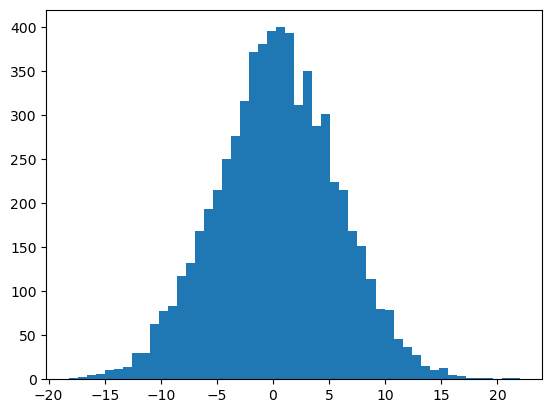

In [77]:
plt.hist(hpreact.view(-1).tolist(), 50)

(array([2092.,  145.,   86.,   75.,   50.,   45.,   24.,   29.,   29.,
          38.,   18.,   34.,   27.,   20.,   17.,   17.,   23.,   12.,
          23.,   15.,   29.,   36.,   36.,   16.,    3.,   13.,   26.,
          30.,   30.,   14.,   12.,   35.,   36.,   24.,   21.,   25.,
          25.,   22.,   20.,   38.,   21.,   39.,   36.,   37.,   44.,
          72.,   75.,  109.,  156., 2501.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

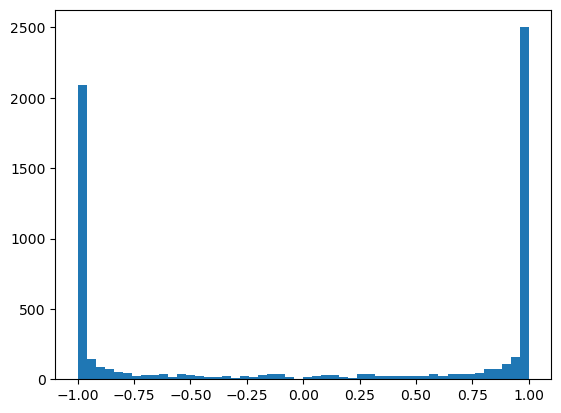

In [ ]:

plt.hist(h.view(-1).tolist(), 50)

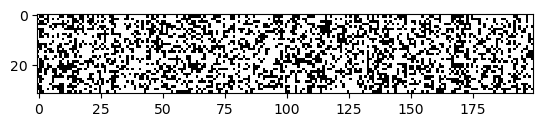

In [79]:
import matplotlib.pyplot as plt
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

### After fixing

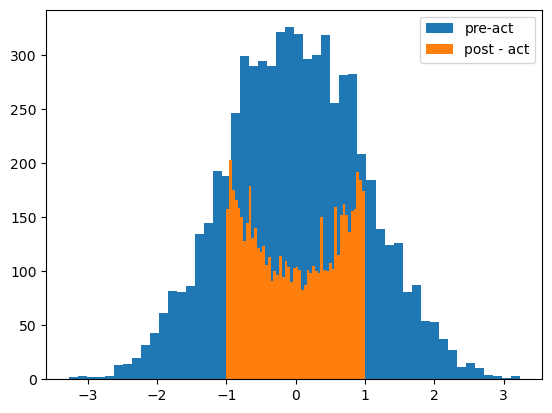

In [172]:
plt.hist(hpreact.view(-1).tolist(), 50,label = 'pre-act')
plt.hist(h.view(-1).tolist(), 50, label = 'post - act')
plt.legend()

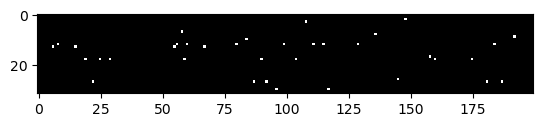

In [162]:
import matplotlib.pyplot as plt
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

After using He initialisation

(array([592., 289., 194., 165., 147., 151., 140., 118.,  98.,  92.,  93.,
         57.,  79.,  85.,  73.,  68.,  72.,  80.,  82.,  65.,  63.,  68.,
         51.,  77.,  59.,  68.,  69.,  67.,  75.,  80.,  67.,  62.,  80.,
         69.,  82.,  74.,  75.,  89.,  73.,  96.,  97.,  92., 109., 123.,
        145., 134., 179., 240., 330., 767.]),
 array([-9.99991417e-01, -9.59991689e-01, -9.19991961e-01, -8.79992232e-01,
        -8.39992504e-01, -7.99992776e-01, -7.59993048e-01, -7.19993320e-01,
        -6.79993591e-01, -6.39993863e-01, -5.99994135e-01, -5.59994407e-01,
        -5.19994678e-01, -4.79994950e-01, -4.39995222e-01, -3.99995494e-01,
        -3.59995766e-01, -3.19996037e-01, -2.79996309e-01, -2.39996581e-01,
        -1.99996853e-01, -1.59997125e-01, -1.19997396e-01, -7.99976683e-02,
        -3.99979401e-02,  1.78813934e-06,  4.00015163e-02,  8.00012445e-02,
         1.20000973e-01,  1.60000701e-01,  2.00000429e-01,  2.40000157e-01,
         2.79999886e-01,  3.19999614e-01,  3.59999

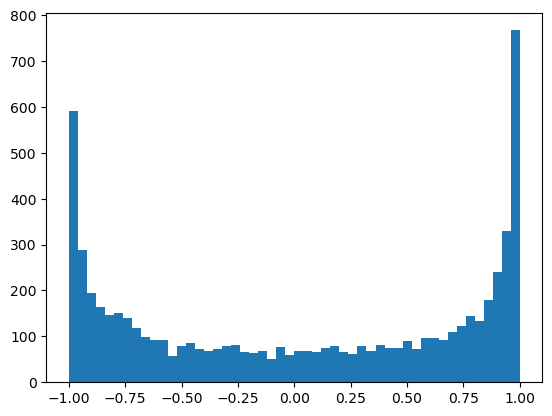

In [106]:
plt.hist(h.view(-1).tolist(), 50, label = 'post - act')


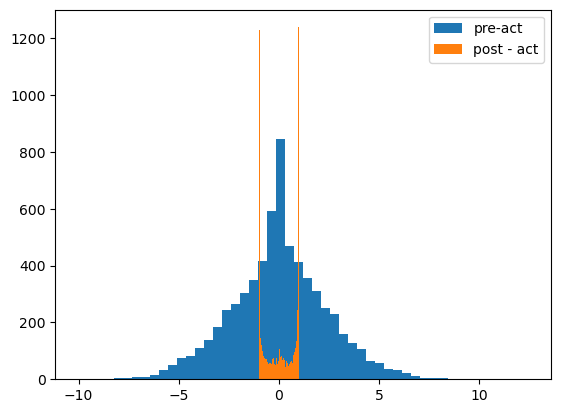

In [140]:
plt.hist(hpreact.view(-1).tolist(), 50,label = 'pre-act')
plt.hist(h.view(-1).tolist(), 50, label = 'post - act')
plt.legend()

In [32]:
logits[0]

tensor([-1.1090,  1.4539, -1.4150,  1.8814,  1.6854,  0.9212, -2.5169, -0.6605,
         0.4237,  0.9222,  0.5677,  1.3343, -1.6767, -0.2955, -0.0284, -0.7105,
        -0.3450, -1.1987, -0.1910,  1.0562,  0.5373,  0.0206, -0.1885, -0.1058,
         0.4466,  0.5713,  1.0347], grad_fn=<SelectBackward0>)

In [82]:
loss.item()

2.5914981365203857

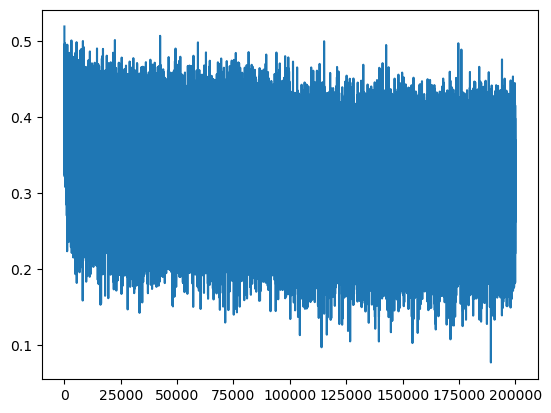

In [141]:
plt.plot(stepi, lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    X,y = {
        'train' : [Xtr, Ytr],
        'val' : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]

    emb = C[X]
    h = torch.tanh(emb * W1 + b1)
    logits = h * W2 + b2
    loss = F.cross_entropy(logits, y).log()
    return loss
print("train loss :", split_loss('train'))
print('Val loos:', split_loss('val'))


    

In [1]:
class Linear:
    def __init__(self, fan_in, fan_out, bias):
        self.weight = torch.randn((fan_in, fan_out))
        self.bais = torch.randn((1,fan_out)) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bais
        return self.out
    def parameters(self):
        return [self.weight + ([] if self.bias is not None else self.bais)]
    
#-------------------------------------------------------------------------------------------------------------------------

class batchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.001):
        self.momentum = momentum
        self.eps = eps
        self.training = True
        # trainable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Non trainable parameters
        self.bnmeanrunning = self.zeros(dim)
        self.bnvarrunning = self.ones(dim)

    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keep_dim = True)
            xvar = x.var(0, keep_dim = True)
            
        else:
            xmean = self.bnmeanrunning
            xvar = self.bnvarrunning
        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.bnmeanrunning = (1 - self.momentum) * self.bnmeanrunning + self.momentum * xmean
                self.bnvarrunning  = (1 - self.momentum) * self.bnvarrunning  + self.momentum * xvar

        return self.out            
    
    def parameters(self):
        return [self.gamma, self.beta]
    
#-------------------------------------------------------------------------------------------------------------------------

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

#-------------------------------------------------------------------------------------------------------------------------

class Embeddings:
    def __init__(self, n_embeddings, embedding_dim,):
        self.weights = torch.randn((n_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weights[IX]
        return self.out
    def parameters(self):
        return [self.weights]
    
#-------------------------------------------------------------------------------------------------------------------------

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in layers for p in layer.parameters()]
    

In [ ]:
n_embed = 10
n_hidden = 200
block_size = 3

model = Sequential([
    Embeddings(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden, bias = False), BatchNorm1d(n_hidden),tanh(),
    Linear(n_hidden,vocab_size)
])
